In [1]:
%%html
<style>
    .container { width:100% !important; }
</style>

In [2]:

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, FloatType
from pyspark.sql.functions import mean, min, max, count, regexp_replace, percentile_approx


In [3]:
spark = SparkSession.builder.appName("World Happiness Report").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/03 09:02:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Preprocessing/Cleaning
As part of the preprocessing step, let's drop some columns that won't be useful for us and fix the names of the headers.
____________________________________________________________________________________________

In [4]:
df = spark.read.csv("datasets/world_happiness/2022.csv", header = True, inferSchema = True)
# df = df.drop(col("Whisker-high")).drop(col("Whisker-low"))
# df = df.drop(col("`Dystopia (1.83) + residual`")) #careful with spacing - use ` `

In [5]:
#Let's take a look at the columns and their types
df.dtypes

[('RANK', 'int'),
 ('Country', 'string'),
 ('Happiness score', 'string'),
 ('Whisker-high', 'string'),
 ('Whisker-low', 'string'),
 ('Dystopia (1.83) + residual', 'string'),
 ('Explained by: GDP per capita', 'string'),
 ('Explained by: Social support', 'string'),
 ('Explained by: Healthy life expectancy', 'string'),
 ('Explained by: Freedom to make life choices', 'string'),
 ('Explained by: Generosity', 'string'),
 ('Explained by: Perceptions of corruption', 'string')]

### Notice that we need to convert some string types to float types for machine learning purposes. Let's first rename our columns so they're easier to work with and we don't have to worry about special characters.
____________________________________________________________________________________________

In [6]:
df = (df.withColumnRenamed("RANK", "rank")
      .withColumnRenamed("Country", "country")
      .withColumnRenamed("Happiness score", "happiness_score")
      .withColumnRenamed("Whisker-high", "whisker_high")
      .withColumnRenamed("Whisker-low", "whisker_low")
      .withColumnRenamed("Dystopia (1.83) + residual", "dystopia_183_residual")
      .withColumnRenamed("Explained by: GDP per capita", "gdp_per_capita")
      .withColumnRenamed("Explained by: Social support", "social_support")
      .withColumnRenamed("Explained by: Healthy life expectancy", "healthy_life_expectancy")
      .withColumnRenamed("Explained by: Freedom to make life choices", "freedom_to_make_life_choices")
      .withColumnRenamed("Explained by: Generosity", "generosity")
      .withColumnRenamed("Explained by: Perceptions of corruption", "perception_of_corruption")
     )

In [7]:
df.dtypes

[('rank', 'int'),
 ('country', 'string'),
 ('happiness_score', 'string'),
 ('whisker_high', 'string'),
 ('whisker_low', 'string'),
 ('dystopia_183_residual', 'string'),
 ('gdp_per_capita', 'string'),
 ('social_support', 'string'),
 ('healthy_life_expectancy', 'string'),
 ('freedom_to_make_life_choices', 'string'),
 ('generosity', 'string'),
 ('perception_of_corruption', 'string')]

### Drop NA values

In [8]:
#Let's see if we have any null values and then drop them if we do. 
# Drop all rows with any null values
df = df.na.drop()

### Let's grab some descriptive statistics for scores.

In [9]:
from pyspark.sql.functions import col

# Assume that `df` is your PySpark DataFrame

# Loop through each column
for col_name in df.columns:
    # Replace the "," with "."
    df = df.withColumn(col_name, regexp_replace(col_name, ",", "."))



In [10]:

df.select('happiness_score').describe().show()

+-------+------------------+
|summary|   happiness_score|
+-------+------------------+
|  count|               146|
|   mean|  5.55357534246575|
| stddev|1.0868426072366928|
|    min|             2.404|
|    max|             7.821|
+-------+------------------+



In [11]:
df.select(percentile_approx("happiness_score", 0.25).alias("25th_percentile"),
                                percentile_approx("happiness_score", 0.5).alias("50th_percentile"),
                                percentile_approx("happiness_score", 0.75).alias("75th_percentile")).show()

+---------------+---------------+---------------+
|25th_percentile|50th_percentile|75th_percentile|
+---------------+---------------+---------------+
|          4.888|          5.559|          6.309|
+---------------+---------------+---------------+



In [12]:
def percentile_val(df,col,perc):
    df = df.select(percentile_approx(col,perc).alias("percentile_val"))
    return df

In [13]:
(percentile_val(df, 'happiness_score', 0.5)).show()

+--------------+
|percentile_val|
+--------------+
|         5.559|
+--------------+



# Visual Analysis

In [14]:

# happiness_df = df.select('country','happiness_score').where(col('happiness_score') > 5.559).toPandas()

grouped_df = df.groupBy('country').agg(max('happiness_score').alias("desc_score"))
top_10_df = grouped_df.sort('desc_score', ascending=False).limit(10)
top_10_df = top_10_df.toPandas()


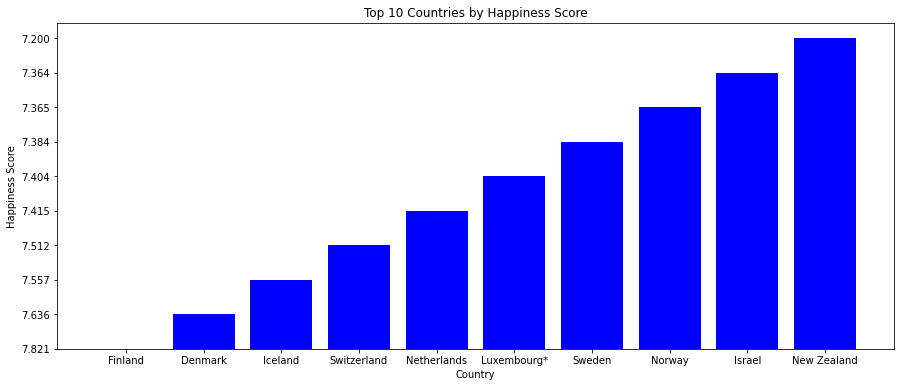

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(top_10_df['country'], top_10_df['desc_score'], color='b')
ax.set_title('Top 10 Countries by Happiness Score')
ax.set_xlabel('Country')
ax.set_ylabel('Happiness Score')
plt.show()

In [16]:
num_df = df.drop('rank').drop('country')

for col_name in num_df.columns:
    num_df = num_df.withColumn(col_name, col(col_name).cast(FloatType()))

In [17]:
num_df=num_df.toPandas()

In [18]:
corr_df = num_df.corr()

<AxesSubplot:>

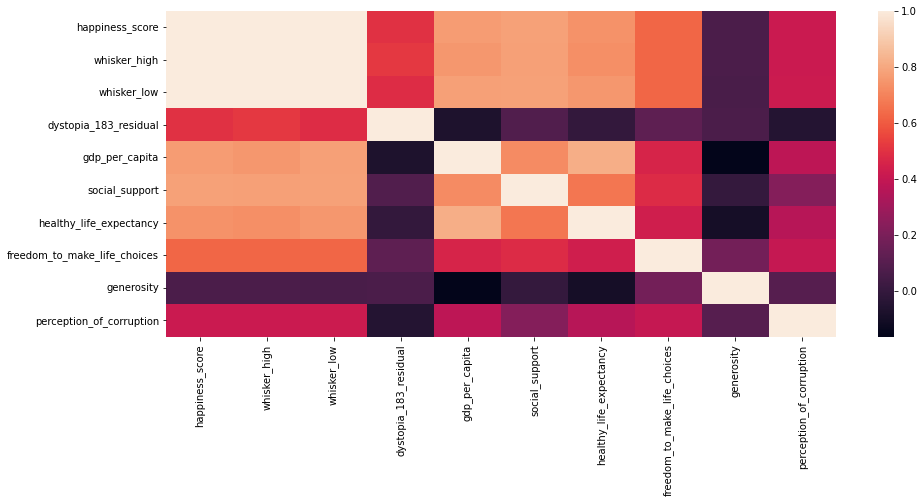

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(num_df.corr())

In [20]:
corr_df_interesting = corr_df.where(abs(corr_df) > 0.7)
display(corr_df_interesting)

,happiness_score,whisker_high,whisker_low,dystopia_183_residual,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perception_of_corruption
happiness_score,1.000000,0.999333,0.999383,NaN,0.763677,0.777889,0.740260,NaN,NaN,NaN
whisker_high,0.999333,1.000000,0.997434,NaN,0.752104,0.773375,0.727611,NaN,NaN,NaN
whisker_low,0.999383,0.997434,1.000000,NaN,0.773844,0.781302,0.751530,NaN,NaN,NaN
dystopia_183_residual,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
gdp_per_capita,0.763677,0.752104,0.773844,NaN,1.000000,0.722421,0.815386,NaN,NaN,NaN
social_support,0.777889,0.773375,0.781302,NaN,0.722421,1.000000,NaN,NaN,NaN,NaN
healthy_life_expectancy,0.740260,0.727611,0.751530,NaN,0.815386,NaN,1.000000,NaN,NaN,NaN
freedom_to_make_life_choices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
generosity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
perception_of_corruption,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [21]:
test_df = df.select('country','happiness_score').toPandas()

In [22]:
type(test_df)

pandas.core.frame.DataFrame

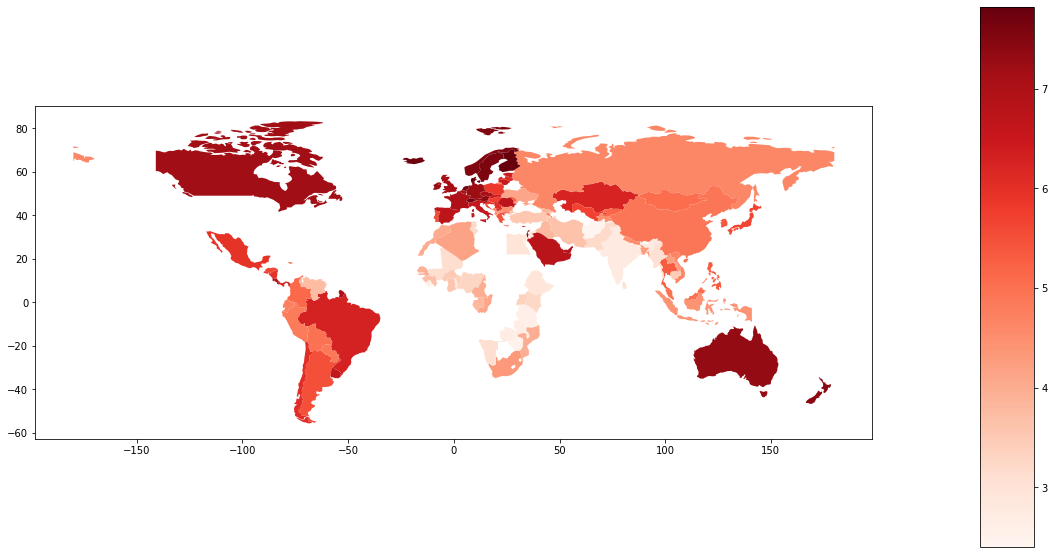

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a list of countries
# countries = ['United States', 'Canada', 'Mexico', 'Brazil', 'Argentina']

# Generate artificial happiness scores for each country
# scores = pd.DataFrame({'Country': countries, 'Happiness Score': np.random.rand(len(countries))})

scores = test_df = df.select('country','happiness_score').toPandas()

# Merge the world map with the happiness scores data
world = world.merge(scores, left_on='name', right_on='country')

# Define the color map for the happiness scores
cmap = 'Reds'

# Plot the map with happiness scores as colors
fig, ax = plt.subplots(figsize=(15,25))
ax.set_aspect('equal')
world.plot(
    ax=ax,
    column='happiness_score',
    cmap=cmap
)
# Create a separate axis for the colorbar
cax = fig.add_axes([1, 0.35, 0.05, 0.3])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=world['happiness_score'].min(), vmax=world['happiness_score'].max()))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.show()
